# Import Libraries

In [1]:
import os
import sys
import pypots
import numpy as np
import benchpots
import matplotlib.pyplot as plt
from pypots.optim import Adam
from pypots.imputation import SAITS, BRITS, USGAN, GPVAE, MRNN
from pypots.utils.random import set_random_seed
from functions.toolkits import toolkits
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from MAEModify.error import calc_mae
from pypotsModify.benchpotsMAE.datasets import preprocess_physionet2012 as preprocess_physionet2012


2025-05-09 22:21:10.352033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746840070.369486  280088 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746840070.374714  280088 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 22:21:10.391876: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidge


████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



# Load Dataset

In [2]:
set_random_seed()
physionet2012_dataset = preprocess_physionet2012(subset="all", rate=0.1, normalization=1)
print(physionet2012_dataset.keys())

2025-05-09 22:21:13 [INFO]: Have set the random seed as 2022 for numpy and pytorch.
2025-05-09 22:21:13 [INFO]: You're using dataset physionet_2012, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/physionet_2012
2025-05-09 22:21:13 [INFO]: Dataset physionet_2012 has already been downloaded. Processing directly...
2025-05-09 22:21:13 [INFO]: Dataset physionet_2012 has already been cached. Loading from cache directly...
2025-05-09 22:21:13 [INFO]: Loaded successfully!
2025-05-09 22:21:28 [WARNING]: Note that physionet_2012 has sparse observations in the time series, hence we don't add additional missing values to the training dataset. 
2025-05-09 22:21:28 [WARNING]: Note that physionet_2012 has sparse observations in the time series, hence we don't add additional missing values to the training dataset. 
2025-05-09 22:21:29 [INFO]: 68807 values masked out in the val set as ground t

dict_keys(['n_classes', 'n_steps', 'n_features', 'scaler', 'train_X', 'train_y', 'train_ICUType', 'val_X', 'val_y', 'val_ICUType', 'test_X', 'test_y', 'test_ICUType', 'female_gender_test_X', 'female_gender_test_y', 'test_ICUType_female_gender', 'male_gender_test_X', 'male_gender_test_y', 'test_ICUType_male_gender', 'undefined_gender_test_X', 'undefined_gender_test_y', 'test_ICUType_undefined_gender', 'more_than_or_equal_to_65_test_X', 'more_than_or_equal_to_65_test_y', 'test_ICUType_more_than_or_equal_to_65', 'less_than_65_test_X', 'less_than_65_test_y', 'test_ICUType_less_than_65', 'classificacao_undefined_test_X', 'classificacao_undefined_test_y', 'test_ICUType_classificacao_undefined', 'classificacao_baixo_peso_test_X', 'classificacao_baixo_peso_test_y', 'test_ICUType_classificao_baixo_peso', 'classificacao_normal_peso_test_X', 'classificacao_normal_peso_test_y', 'test_ICUType_classificacao_normal_peso', 'classificacao_sobrepeso_test_X', 'classificacao_sobrepeso_test_y', 'test_ICUTy

In [3]:
dataset_for_training, dataset_for_validating, dataset_for_testing_ori, dataset_for_testing = toolkits.separating_dataset(physionet2012_dataset)

In [4]:
dataset_for_testing_ori= toolkits.dict_to_list(dataset_for_testing_ori)
dataset_for_testing = toolkits.dict_to_list(dataset_for_testing)

In [5]:
indicating_mask_subgroup, test_X_ori_subgroup = toolkits.components_mae(dataset_for_testing_ori, dataset_for_testing)

# Train/Load Models

## SAITS

In [6]:
saits = SAITS(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    n_layers=1,
    d_model=256,
    d_ffn=128,
    n_heads=4,
    d_k=64,
    d_v=64,
    dropout=0.1,
    ORT_weight=1,  
    MIT_weight=1,
    batch_size=32,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-05-09 22:21:29 [INFO]: No given device, using default device: cpu
2025-05-09 22:21:29 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-09 22:21:29 [INFO]: Using customized MAE as the training loss function.
2025-05-09 22:21:29 [INFO]: Using customized MSE as the validation metric function.
2025-05-09 22:21:29 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 720,182


In [7]:
saits.load("../mae/tutorial_results/imputation/saits/20250422_T181642/SAITS.pypots")

2025-05-09 22:21:29 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/saits/20250422_T181642/SAITS.pypots


## BRITS

In [8]:
brits = BRITS(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=128,
    batch_size=32,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-05-09 22:21:29 [INFO]: No given device, using default device: cpu
2025-05-09 22:21:29 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-09 22:21:29 [INFO]: Using customized MAE as the training loss function.
2025-05-09 22:21:29 [INFO]: Using customized MSE as the validation metric function.
2025-05-09 22:21:29 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 239,344


In [9]:
brits.load("../mae/tutorial_results/imputation/brits/20250422_T181643/BRITS.pypots")

2025-05-09 22:21:29 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/brits/20250422_T181643/BRITS.pypots


## US-GAN

In [10]:
us_gan = USGAN(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=256,
    lambda_mse=1,
    dropout=0.1,
    G_steps=1,
    D_steps=1,
    batch_size=32,
    epochs=10,
    patience=3,
    G_optimizer=Adam(lr=1e-3),
    D_optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-05-09 22:21:29 [INFO]: No given device, using default device: cpu
2025-05-09 22:21:29 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-09 22:21:29 [INFO]: USGAN initialized with the given hyperparameters, the number of trainable parameters: 1,258,517


In [11]:
us_gan.load("../mae/tutorial_results/imputation/us_gan/20250422_T181643/USGAN.pypots")

2025-05-09 22:21:29 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/us_gan/20250422_T181643/USGAN.pypots


## GP-VAE

In [12]:
gp_vae = GPVAE(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    latent_size=37,
    encoder_sizes=(128,128),
    decoder_sizes=(256,256),
    kernel="cauchy",
    beta=0.2,
    M=1,
    K=1,
    sigma=1.005,
    length_scale=7.0,
    kernel_scales=1,
    window_size=24,
    batch_size=32,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-05-09 22:21:29 [INFO]: No given device, using default device: cpu
2025-05-09 22:21:29 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-09 22:21:29 [INFO]: GPVAE initialized with the given hyperparameters, the number of trainable parameters: 229,652


In [13]:
gp_vae.load("../mae/tutorial_results/imputation/gp_vae/20250422_T181643/GPVAE.pypots")

2025-05-09 22:21:29 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/gp_vae/20250422_T181643/GPVAE.pypots


## MRNN

In [14]:
mrnn = MRNN(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=128,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-05-09 22:21:29 [INFO]: No given device, using default device: cpu
2025-05-09 22:21:29 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-09 22:21:29 [INFO]: Using customized RMSE as the training loss function.
2025-05-09 22:21:29 [INFO]: Using customized MSE as the validation metric function.
2025-05-09 22:21:29 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 107,951


In [15]:
mrnn.load("../mae/tutorial_results/imputation/mrnn/20250422_T181643/MRNN.pypots")

2025-05-09 22:21:29 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/mrnn/20250422_T181643/MRNN.pypots


# Imputation Models

## SAITS

In [16]:
saits_imputation = []
for i in range(len(dataset_for_testing)):
    _dict = {"X":dataset_for_testing[i]}
    saits_result = saits.predict(_dict)
    saits_imputation.append(saits_result['imputation'])

## BRITS

In [17]:
brits_imputation = []
for i in range(len(dataset_for_testing)):
    _dict = {"X":dataset_for_testing[i]}
    brits_result = brits.predict(_dict)
    brits_imputation.append(brits_result['imputation'])

## US-GAN

In [18]:
us_gan_imputation = []
for i in range(len(dataset_for_testing)):
    _dict = {"X":dataset_for_testing[i]}
    us_gan_result = us_gan.predict(_dict)
    us_gan_imputation.append(us_gan_result['imputation'])

## GP-VAE

In [19]:
gp_vae_imputation = []
for i in range(len(dataset_for_testing)):
    _dict = {"X":dataset_for_testing[i]}
    gp_vae_result = gp_vae.predict(_dict)
    gp_vae_imputation.append(gp_vae_result['imputation'])

## MRNN

In [20]:
mrnn_imputation = []
for i in range(len(dataset_for_testing)):
    _dict = {"X":dataset_for_testing[i]}
    mrnn_result = mrnn.predict(_dict)
    mrnn_imputation.append(mrnn_result['imputation'])

# AE/MAE Models

## SAITS

In [21]:
saits_mae = []
saits_ae = []

for i in range(len(saits_imputation)):
    aux_mae, aux_ae = calc_mae(saits_imputation[i], test_X_ori_subgroup[i], indicating_mask_subgroup[i])
    saits_mae.append(aux_mae)
    saits_ae.append(aux_ae)

## BRITS

In [22]:
brits_mae = []
brits_ae = []

for i in range(len(brits_imputation)):
    aux_mae, aux_ae = calc_mae(brits_imputation[i], test_X_ori_subgroup[i], indicating_mask_subgroup[i])
    brits_mae.append(aux_mae)
    brits_ae.append(aux_ae)

## USGAN

In [23]:
us_gan_mae = []
us_gan_ae = []

for i in range(len(us_gan_imputation)):
    aux_mae, aux_ae = calc_mae(us_gan_imputation[i], test_X_ori_subgroup[i], indicating_mask_subgroup[i])
    us_gan_mae.append(aux_mae)
    us_gan_ae.append(aux_ae)

## GPVAE

In [24]:
gp_vae_mae = []
gp_vae_ae = []

for i in range(len(gp_vae_imputation)):
    gp_vae_imputation_fix = np.squeeze(gp_vae_imputation[i], axis=1)
    aux_mae, aux_ae = calc_mae(gp_vae_imputation_fix, test_X_ori_subgroup[i], indicating_mask_subgroup[i])
    gp_vae_mae.append(aux_mae)
    gp_vae_ae.append(aux_ae)

## MRNN

In [25]:
mrnn_mae = []
mrnn_ae = []

for i in range(len(mrnn_imputation)):
    aux_mae, aux_ae = calc_mae(mrnn_imputation[i], test_X_ori_subgroup[i], indicating_mask_subgroup[i])
    mrnn_mae.append(aux_mae)
    mrnn_ae.append(aux_ae)

# Gini Models

## SAITS

In [26]:
subgroups = [1,2,4,5,6,7,8,9,10]
for i in subgroups:
    saits_ae[i] = saits_ae[i].reshape(len(saits_ae[i]) *48 * 37)

In [27]:
for i in subgroups:
    indicating_mask_subgroup[i] = indicating_mask_subgroup[i].reshape(len(indicating_mask_subgroup[i])*48*37)

In [28]:
saits_ae_mask = []
ae_aux = []

for i in subgroups:
    for j in range(len(indicating_mask_subgroup[i])):
        if(indicating_mask_subgroup[i][j] == True):
            ae_aux.append(saits_ae[i][j])
    
    saits_ae_mask.append(np.array(ae_aux))
    ae_aux = []



In [29]:
saits_gini = []

for i in range(len(saits_ae_mask)):
    saits_gini.append(toolkits.gini(saits_ae_mask[i]))

In [30]:
saits_gini

[np.float64(0.6162045348542815),
 np.float64(0.6197027886996627),
 np.float64(0.6145147812615168),
 np.float64(0.6232137502128834),
 np.float64(0.6217452117715003),
 np.float64(0.6142161604225598),
 np.float64(0.626692129854618),
 np.float64(0.6179459535418275),
 np.float64(0.6113996965634747)]

## BRITS

In [31]:
for i in subgroups:
    brits_ae[i] = brits_ae[i].reshape(len(brits_ae[i]) *48 * 37)

In [32]:
brits_ae_mask = []
ae_aux = []

for i in subgroups:
    for j in range(len(indicating_mask_subgroup[i])):
        if(indicating_mask_subgroup[i][j] == True):
            ae_aux.append(brits_ae[i][j])
    
    brits_ae_mask.append(np.array(ae_aux))
    ae_aux = []


In [33]:
brits_gini = []

for i in range(len(brits_ae_mask)):
    brits_gini.append(toolkits.gini(brits_ae_mask[i]))

In [34]:
brits_gini

[np.float64(0.6300982870406782),
 np.float64(0.6388110897282673),
 np.float64(0.6280031047917385),
 np.float64(0.6388286699825989),
 np.float64(0.6346061133914975),
 np.float64(0.6271978187624645),
 np.float64(0.6720157024636544),
 np.float64(0.6344357954419007),
 np.float64(0.6315117932286323)]

## US-GAN

In [35]:
for i in subgroups:
    us_gan_ae[i] = us_gan_ae[i].reshape(len(us_gan_ae[i]) *48 * 37)

In [36]:
usgan_ae_mask = []
ae_aux = []

for i in subgroups:
    for j in range(len(indicating_mask_subgroup[i])):
        if(indicating_mask_subgroup[i][j] == True):
            ae_aux.append(us_gan_ae[i][j])
    
    usgan_ae_mask.append(np.array(ae_aux))
    ae_aux = []


In [37]:
usgan_gini = []

for i in range(len(usgan_ae_mask)):
    usgan_gini.append(toolkits.gini(usgan_ae_mask[i]))

In [38]:
usgan_gini

[np.float64(0.5718148159471921),
 np.float64(0.5803544051223628),
 np.float64(0.5774730231156899),
 np.float64(0.580178056209925),
 np.float64(0.5761024498508667),
 np.float64(0.5780628040153069),
 np.float64(0.5936369896748122),
 np.float64(0.5813985858793358),
 np.float64(0.5677059000268629)]

## GP-VAE

In [39]:
for i in subgroups:
    gp_vae_ae[i] = gp_vae_ae[i].reshape(len(gp_vae_ae[i]) *48 * 37)

In [40]:
gpvae_ae_mask = []
ae_aux = []

for i in subgroups:
    for j in range(len(indicating_mask_subgroup[i])):
        if(indicating_mask_subgroup[i][j] == True):
            ae_aux.append(gp_vae_ae[i][j])
    
    gpvae_ae_mask.append(np.array(ae_aux))
    ae_aux = []


In [41]:
gpvae_gini = []

for i in range(len(gpvae_ae_mask)):
    gpvae_gini.append(toolkits.gini(gpvae_ae_mask[i]))

In [42]:
gpvae_gini

[np.float64(0.5046826857655864),
 np.float64(0.5112476735624192),
 np.float64(0.5051199616717161),
 np.float64(0.5139891122375779),
 np.float64(0.5097943400198903),
 np.float64(0.5027343295465196),
 np.float64(0.51182703937627),
 np.float64(0.5121291254477807),
 np.float64(0.5005721463638517)]

## MRNN

In [43]:
for i in subgroups:
    mrnn_ae[i] = mrnn_ae[i].reshape(len(mrnn_ae[i]) *48 * 37)

In [44]:
mrnn_ae_mask = []
ae_aux = []

for i in subgroups:
    for j in range(len(indicating_mask_subgroup[i])):
        if(indicating_mask_subgroup[i][j] == True):
            ae_aux.append(mrnn_ae[i][j])
    
    mrnn_ae_mask.append(np.array(ae_aux))
    ae_aux = []


In [45]:
mrnn_gini = []

for i in range(len(mrnn_ae_mask)):
    mrnn_gini.append(toolkits.gini(mrnn_ae_mask[i]))

In [46]:
mrnn_gini

[np.float64(0.43002753305947317),
 np.float64(0.4441086247803958),
 np.float64(0.43137377853819125),
 np.float64(0.45029890787432914),
 np.float64(0.4427413965818747),
 np.float64(0.43943918886268496),
 np.float64(0.42785396776914664),
 np.float64(0.43940635885449364),
 np.float64(0.43933021406437534)]

# Lorenz curve 

In [47]:
def lorenz_curve_5(X1, X2, X3, X4, X5,title, labels=None, colors=None):
    arrays = [X1, X2, X3, X4, X5]
        
    if labels is None:
        labels = ["SAITS", "BRITS", "US-GAN", "GP-VAE", "MRNN"]
        if colors is None:
            colors = ['blue', 'green', 'orange', 'purple', 'red']
        
        fig, ax = plt.subplots(figsize=[6,6])

        for i, X in enumerate(arrays):
            X = np.sort(X)
            X_lorenz = X.cumsum() / X.sum()
            X_lorenz = np.insert(X_lorenz, 0, 0)
            x_vals = np.linspace(0, 1, len(X_lorenz))

            ax.plot(x_vals, X_lorenz, linewidth=2, label=labels[i], color=colors[i])

        # Linha de igualdade
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='perfect equality')

        ax.set_title(title)
        ax.set_xlabel("Cummulative Share of Imputations")
        ax.set_ylabel("Cummulative Share of Absolute Errors")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

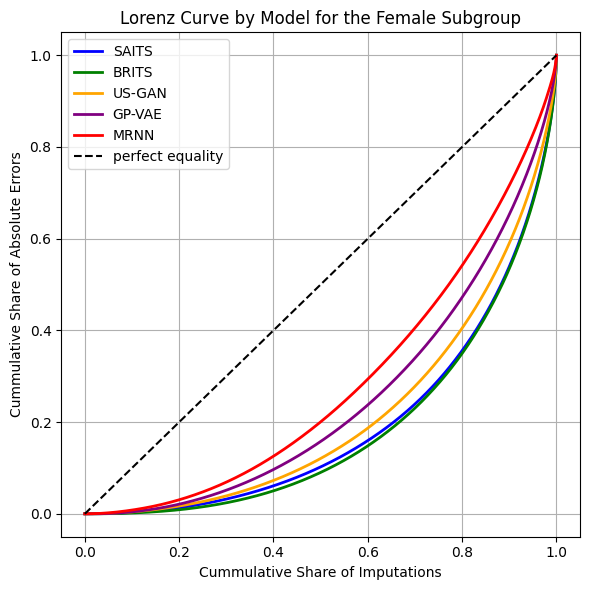

In [48]:
lorenz_curve_5(saits_ae_mask[0], brits_ae_mask[0], usgan_ae_mask[0], gpvae_ae_mask[0], mrnn_ae_mask[0], "Lorenz Curve by Model for the Female Subgroup")

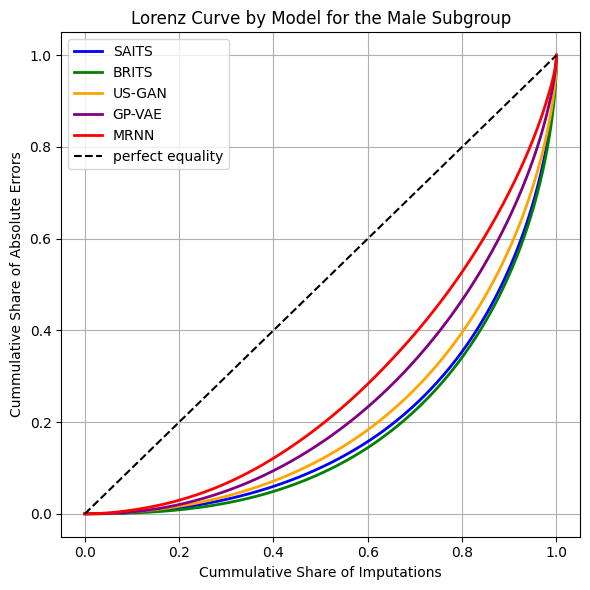

In [49]:
lorenz_curve_5(saits_ae_mask[1], brits_ae_mask[1], usgan_ae_mask[1], gpvae_ae_mask[1], mrnn_ae_mask[1], "Lorenz Curve by Model for the Male Subgroup")

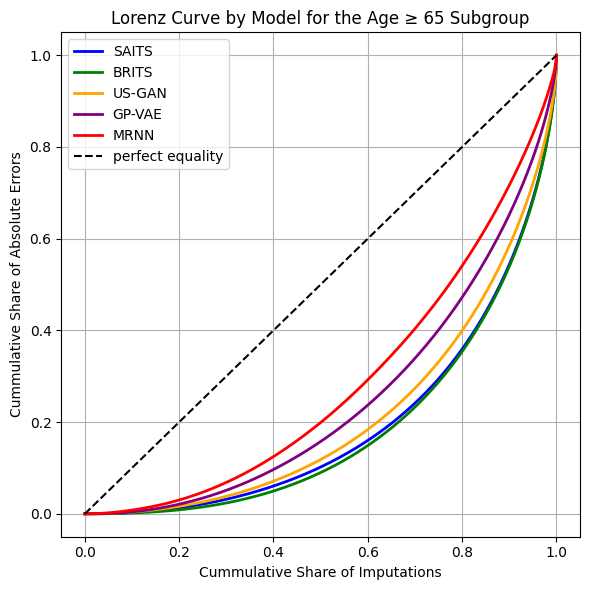

In [50]:
lorenz_curve_5(saits_ae_mask[2], brits_ae_mask[2], usgan_ae_mask[2], gpvae_ae_mask[2], mrnn_ae_mask[2], "Lorenz Curve by Model for the Age ≥ 65 Subgroup")

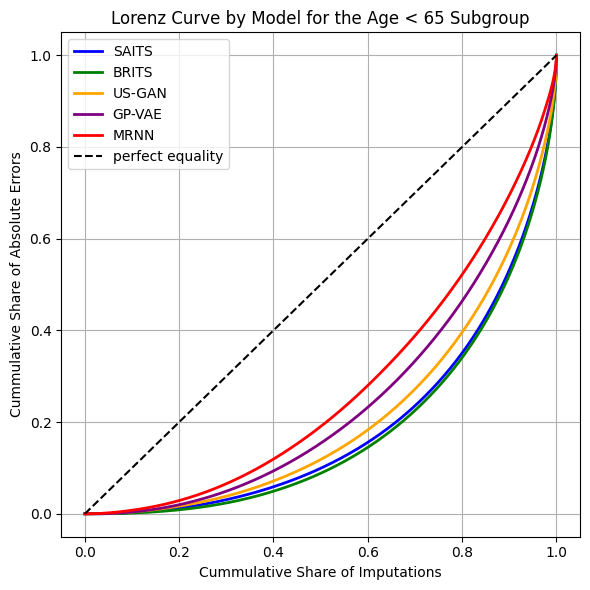

In [51]:
lorenz_curve_5(saits_ae_mask[3], brits_ae_mask[3], usgan_ae_mask[3], gpvae_ae_mask[3], mrnn_ae_mask[3], "Lorenz Curve by Model for the Age < 65 Subgroup")

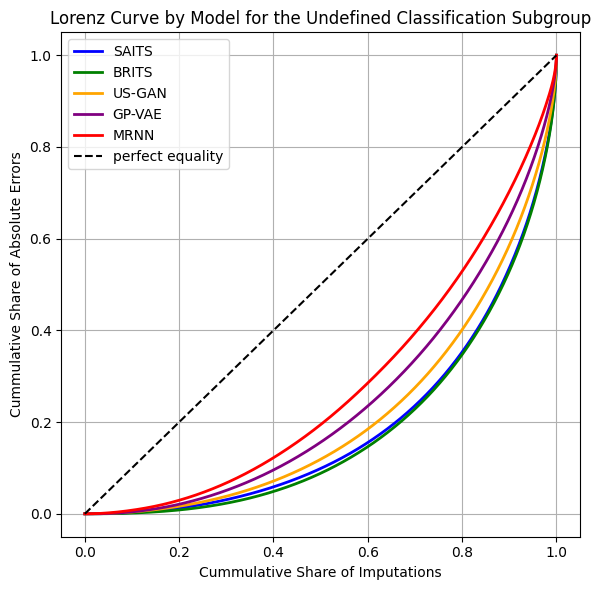

In [52]:
lorenz_curve_5(saits_ae_mask[4], brits_ae_mask[4], usgan_ae_mask[4], gpvae_ae_mask[4], mrnn_ae_mask[4], "Lorenz Curve by Model for the Undefined Classification Subgroup")

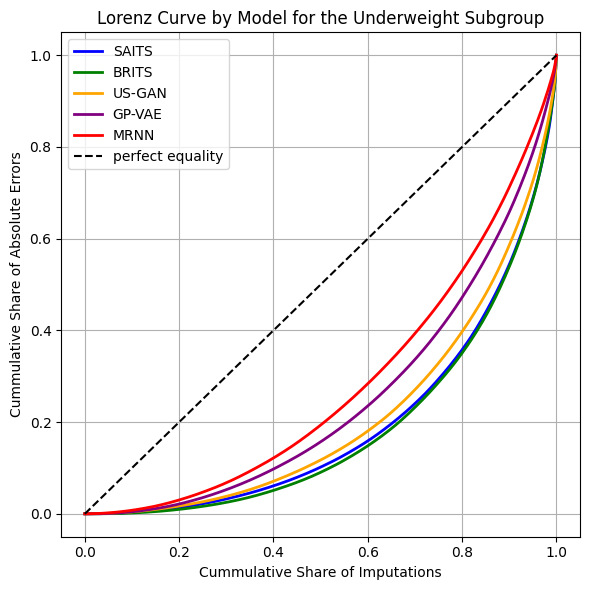

In [53]:
lorenz_curve_5(saits_ae_mask[5], brits_ae_mask[5], usgan_ae_mask[5], gpvae_ae_mask[5], mrnn_ae_mask[5], "Lorenz Curve by Model for the Underweight Subgroup")

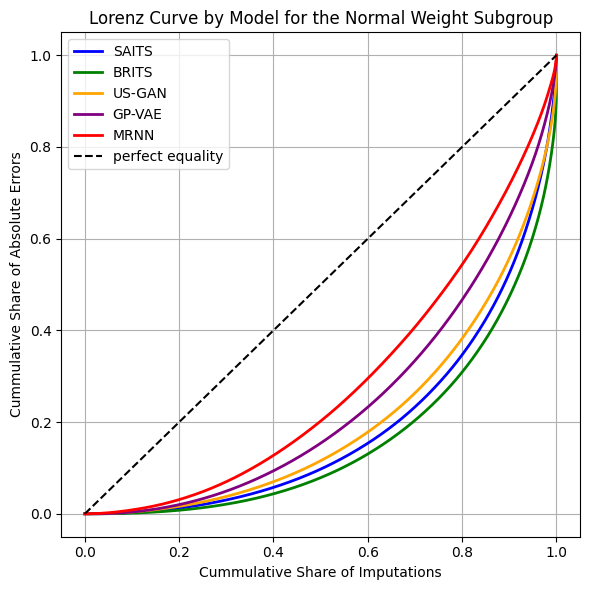

In [54]:
lorenz_curve_5(saits_ae_mask[6], brits_ae_mask[6], usgan_ae_mask[6], gpvae_ae_mask[6], mrnn_ae_mask[6], "Lorenz Curve by Model for the Normal Weight Subgroup")

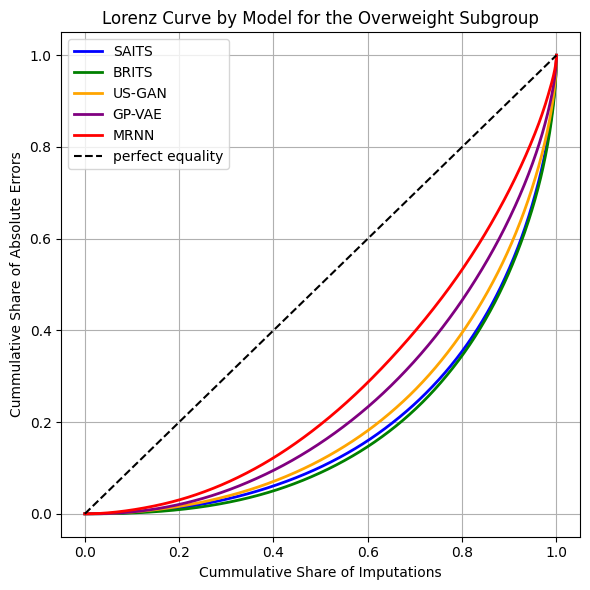

In [55]:
lorenz_curve_5(saits_ae_mask[7], brits_ae_mask[7], usgan_ae_mask[7], gpvae_ae_mask[7], mrnn_ae_mask[7], "Lorenz Curve by Model for the Overweight Subgroup")

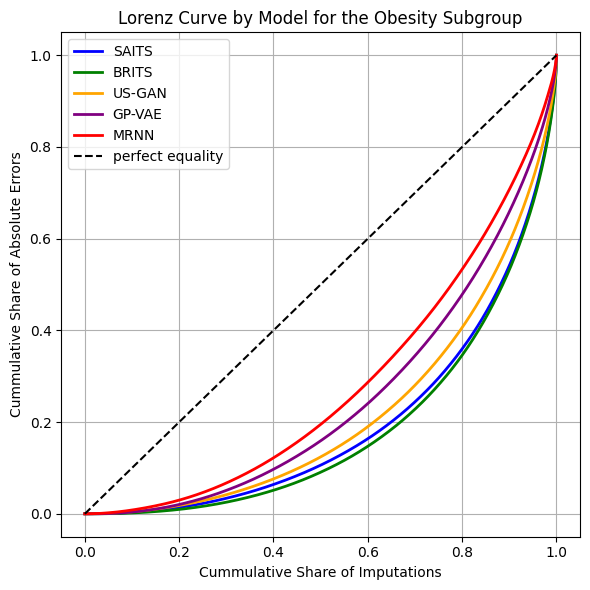

In [56]:
lorenz_curve_5(saits_ae_mask[8], brits_ae_mask[8], usgan_ae_mask[8], gpvae_ae_mask[8], mrnn_ae_mask[8], "Lorenz Curve by Model for the Obesity Subgroup")

# IC Subgroups

## SAITS

In [58]:
bootstrap_saits = []

for i in range(len(saits_ae_mask)):
        bootstrap_saits.append(toolkits.bootstrap_v2(saits_ae_mask, i, 9000))

In [59]:
lower_bound_saits = []
upper_bound_saits = []

for i in range(len(bootstrap_saits)):
    lower_bound_saits.append(np.percentile(bootstrap_saits[i], 2.5))
    upper_bound_saits.append(np.percentile(bootstrap_saits[i], 97.5))

print(lower_bound_saits)
print(upper_bound_saits)

[np.float64(0.6106440552095981), np.float64(0.6144165826669988), np.float64(0.6087816245410871), np.float64(0.6164129051433975), np.float64(0.6148897082114512), np.float64(0.5928541158511192), np.float64(0.6162864144366555), np.float64(0.6079127853346065), np.float64(0.6023724354316273)]
[np.float64(0.6221557562443897), np.float64(0.625339216513228), np.float64(0.6208281069207666), np.float64(0.6303810458831958), np.float64(0.6291783733070796), np.float64(0.6344573177058971), np.float64(0.639510186628189), np.float64(0.6295135269357135), np.float64(0.6208959775160388)]


In [60]:
mean_bound_saits = []

for i in range(len(lower_bound_saits)):
    mean_bound_saits.append((lower_bound_saits[i]+upper_bound_saits[i])/2)

print(mean_bound_saits)

[np.float64(0.6163999057269939), np.float64(0.6198778995901134), np.float64(0.6148048657309269), np.float64(0.6233969755132966), np.float64(0.6220340407592654), np.float64(0.6136557167785082), np.float64(0.6278983005324223), np.float64(0.61871315613516), np.float64(0.611634206473833)]


## BRITS

In [61]:
bootstrap_brits = []

for i in range(len(brits_ae_mask)):
        bootstrap_brits.append(toolkits.bootstrap_v2(brits_ae_mask, i, 9000))

In [62]:
lower_bound_brits = []
upper_bound_brits = []

for i in range(len(bootstrap_brits)):
    lower_bound_brits.append(np.percentile(bootstrap_brits[i], 2.5))
    upper_bound_brits.append(np.percentile(bootstrap_brits[i], 97.5))

print(lower_bound_brits)
print(upper_bound_brits)

[np.float64(0.624675647684854), np.float64(0.6320958843661353), np.float64(0.621474943108814), np.float64(0.6322862588048321), np.float64(0.6282343471976309), np.float64(0.6070408292874659), np.float64(0.6356907432222481), np.float64(0.6244793715786846), np.float64(0.6224871464972953)]
[np.float64(0.6355937992815214), np.float64(0.6463956644735879), np.float64(0.6351093648612915), np.float64(0.6455160893038429), np.float64(0.641362913520291), np.float64(0.6469627207517262), np.float64(0.7218990893151024), np.float64(0.6456239140086372), np.float64(0.6409578305221879)]


In [63]:
mean_bound_brits = []

for i in range(len(lower_bound_brits)):
    mean_bound_brits.append((lower_bound_brits[i]+upper_bound_brits[i])/2)

print(mean_bound_brits)

[np.float64(0.6301347234831877), np.float64(0.6392457744198616), np.float64(0.6282921539850528), np.float64(0.6389011740543376), np.float64(0.634798630358961), np.float64(0.6270017750195961), np.float64(0.6787949162686753), np.float64(0.6350516427936609), np.float64(0.6317224885097417)]


## USGAN

In [64]:
bootstrap_usgan = []

for i in range(len(usgan_ae_mask)):
        bootstrap_usgan.append(toolkits.bootstrap_v2(usgan_ae_mask, i, 9000))

In [65]:
lower_bound_usgan = []
upper_bound_usgan = []

for i in range(len(bootstrap_usgan)):
    lower_bound_usgan.append(np.percentile(bootstrap_usgan[i], 2.5))
    upper_bound_usgan.append(np.percentile(bootstrap_usgan[i], 97.5))

print(lower_bound_usgan)
print(upper_bound_usgan)

[np.float64(0.5666457552931569), np.float64(0.5737875411748112), np.float64(0.5701989822560659), np.float64(0.5738972552825167), np.float64(0.57040255244865), np.float64(0.5583026178037753), np.float64(0.5714345573754265), np.float64(0.5716963929185092), np.float64(0.5593504974597562)]
[np.float64(0.5770866710646977), np.float64(0.5883970623491395), np.float64(0.5861707474544435), np.float64(0.5871532339730616), np.float64(0.5823793348767962), np.float64(0.5977733955146973), np.float64(0.6245438970727794), np.float64(0.5927480272147388), np.float64(0.5765752762501148)]


In [66]:
mean_bound_usgan = []

for i in range(len(lower_bound_usgan)):
    mean_bound_usgan.append((lower_bound_usgan[i]+upper_bound_usgan[i])/2)

print(mean_bound_usgan)

[np.float64(0.5718662131789273), np.float64(0.5810923017619753), np.float64(0.5781848648552548), np.float64(0.5805252446277891), np.float64(0.576390943662723), np.float64(0.5780380066592363), np.float64(0.597989227224103), np.float64(0.582222210066624), np.float64(0.5679628868549356)]


## GPVAE

In [67]:
bootstrap_gpvae = []

for i in range(len(gpvae_ae_mask)):
        bootstrap_gpvae.append(toolkits.bootstrap_v2(gpvae_ae_mask, i, 9000))

In [68]:
lower_bound_gpvae = []
upper_bound_gpvae = []

for i in range(len(bootstrap_gpvae)):
    lower_bound_gpvae.append(np.percentile(bootstrap_gpvae[i], 2.5))
    upper_bound_gpvae.append(np.percentile(bootstrap_gpvae[i], 97.5))

print(lower_bound_gpvae)
print(upper_bound_gpvae)

[np.float64(0.5004560649212902), np.float64(0.507153062142695), np.float64(0.5009108736839697), np.float64(0.508960016466828), np.float64(0.5049155959814454), np.float64(0.48666935481169576), np.float64(0.5037250003655256), np.float64(0.5044051346233409), np.float64(0.49353648687698126)]
[np.float64(0.5089509010330774), np.float64(0.5154196365089426), np.float64(0.5097372235847658), np.float64(0.5193583146425841), np.float64(0.5148621848413154), np.float64(0.5185702394279991), np.float64(0.5213580956982988), np.float64(0.5205794759145888), np.float64(0.5079086167864896)]


In [69]:
mean_bound_gpvae = []

for i in range(len(lower_bound_gpvae)):
    mean_bound_gpvae.append((lower_bound_gpvae[i]+upper_bound_gpvae[i])/2)

print(mean_bound_gpvae)

[np.float64(0.5047034829771838), np.float64(0.5112863493258188), np.float64(0.5053240486343678), np.float64(0.514159165554706), np.float64(0.5098888904113804), np.float64(0.5026197971198474), np.float64(0.5125415480319122), np.float64(0.5124923052689648), np.float64(0.5007225518317354)]


## MRNN

In [70]:
bootstrap_mrnn = []

for i in range(len(mrnn_ae_mask)):
        bootstrap_mrnn.append(toolkits.bootstrap_v2(mrnn_ae_mask, i, 9000))

In [71]:
lower_bound_mrnn = []
upper_bound_mrnn = []

for i in range(len(bootstrap_mrnn)):
    lower_bound_mrnn.append(np.percentile(bootstrap_mrnn[i], 2.5))
    upper_bound_mrnn.append(np.percentile(bootstrap_mrnn[i], 97.5))

print(lower_bound_mrnn)
print(upper_bound_mrnn)

[np.float64(0.42627738050314123), np.float64(0.4405285814910363), np.float64(0.4278612235903279), np.float64(0.4459047096808761), np.float64(0.43835400084865356), np.float64(0.4256107292427363), np.float64(0.4212188852924432), np.float64(0.43310610619789736), np.float64(0.4335163005791434)]
[np.float64(0.43366225482489495), np.float64(0.4476545086116099), np.float64(0.4350955402640434), np.float64(0.4548650637455258), np.float64(0.4474270652331439), np.float64(0.45339274333971746), np.float64(0.4354247192538532), np.float64(0.4464227031202769), np.float64(0.4451970040637381)]


In [72]:
mean_bound_mrnn = []

for i in range(len(lower_bound_mrnn)):
    mean_bound_mrnn.append((lower_bound_mrnn[i]+upper_bound_mrnn[i])/2)

print(mean_bound_mrnn)

[np.float64(0.4299698176640181), np.float64(0.4440915450513231), np.float64(0.4314783819271857), np.float64(0.450384886713201), np.float64(0.44289053304089876), np.float64(0.4395017362912269), np.float64(0.4283218022731482), np.float64(0.4397644046590871), np.float64(0.4393566523214407)]
